In [21]:
import numpy as np

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import StatevectorSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2 as Sampler

## 1) Preparation

### 1.1) Parametrization

In [22]:
n_circuits = 10

shots = 1024

optimization_level = 0

token = ""
channel = "ibm_quantum"
instance = "ibm-q/open/main"

### 1.2) Define multiple quantum circuits

In [23]:
def build_qc(n_qubits):
    
    qr = QuantumRegister(n_qubits, "q")
    cr = ClassicalRegister(n_qubits, "c")
    
    qc = QuantumCircuit(qr, cr)
    
    qc.h(0)
    for i in range(n_qubits-1):
        qc.cx(i, i+1)

    qc.barrier()
    
    for i in range(n_qubits):
        qc.measure(i, i)

    return qc

In [24]:
qc_list = []

for i in range(n_circuits):
    qc_list.append(build_qc(i+2))

### 1.3) Prepare multiple ISA circuits

In [25]:
service = QiskitRuntimeService(channel=channel, instance=instance)
backend = service.least_busy(operational=True, min_num_qubits=n_circuits+2)

print(
    f"Name: {backend.name}\n"
    f"Version: {backend.version}\n"
    f"Qubits: {backend.num_qubits}\n"
)

Name: ibm_kyiv
Version: 2
Qubits: 127



In [26]:
target = backend.target

pm = generate_preset_pass_manager(target=target, optimization_level=optimization_level)

In [27]:
isa_list = []

for qc in qc_list:
    isa_list.append(pm.run(qc))

## 2) Running all the circuits in one job

In [28]:
sampler = Sampler(backend=backend)

job = sampler.run(isa_list, shots=shots)
job_id = job.job_id()
print("Job ID: ", job_id)

Job ID:  cyt499dy2gd00087zq3g


## 3) Postprocessing

### 3.1) Retrieving the job from the ID (optional)

In [29]:
job = service.job(job_id)

### 3.2) Post-processing the results

In [30]:
result = job.result()

In [31]:
def get_hist(index):

    try:
        counts = result[index].data.c.array
    except:
        counts = result[index]["__value__"]["data"]["c"].array
    
    hist = {}
    
    for i in range(len(counts)):
    
        x_binary = "".join([bin(counts[i][j])[2:] for j in range(len(counts[i]))]).zfill(index+2)
    
        hist[x_binary] = hist.get(x_binary, 0) + 1
    
    return hist

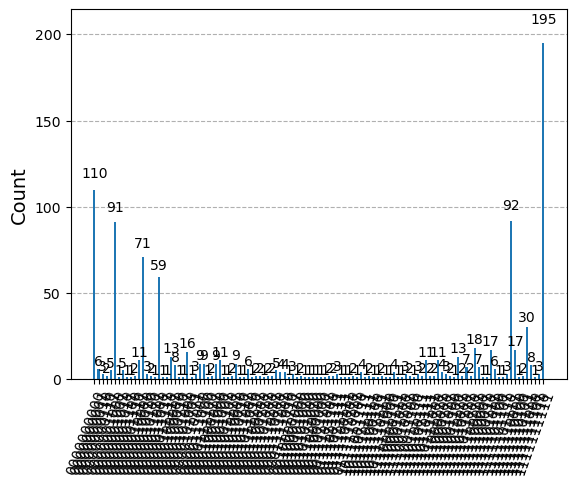

In [42]:
index = 8

hist = get_hist(index)
plot_histogram(hist)

### 3.3) Analyzing the noise level

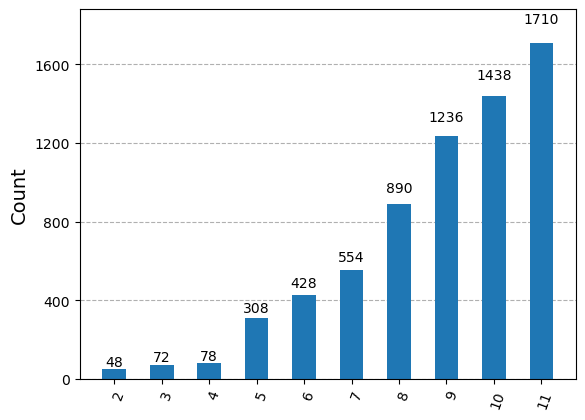

In [33]:
error = {}

for index in range(n_circuits):

    hist = get_hist(index)
    n_qubits = len(list(hist.keys())[0])
    
    counts = 0
    for key in hist.keys():

        if key in ("0"*n_qubits, "1"*n_qubits):
            counts += abs(hist[key] - shots//2)

        else:
            counts += hist[key]

    error[index+2] = counts

plot_histogram(error)